# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [25]:
cd /home/jovyan/dea_intertidal/dea-intertidal/

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [26]:
# pip install -r requirements.in --quiet


### Load packages

In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup


### Set analysis parameters

In [6]:
# Set study area and config
study_area = "gulfcarpentaria1"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '1215'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*
> *Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance*

In [29]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Intertidal elevation

In [32]:
# Model elevation for each pixel
ds, freq, corr, tide_m = elevation(
    study_area=study_area,
    start_date=start_date,
    end_date=end_date,
    config_path=config_path,
)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41159/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41159/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43411,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/41159/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:44691,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/46055/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:43495,


2023-05-08 07:09:30 INFO Study area testing: Loaded custom study area
2023-05-08 07:09:30 INFO Study area testing: Loading satellite data
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-05-08 07:10:33 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 401/401 [00:00<00:00, 871.40it/s] 
2023-05-08 07:10:49 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-05-08 07:10:49 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-05-08 07:10:50 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 62330 to 828 (1.33%)


100%|██████████| 114/114 [00:00<00:00, 199.47it/s]
2023-05-08 07:10:57 INFO Study area testing: Modelling intertidal elevation
2023-05-08 07:10:57 INFO Study area testing: Modelling intertidal uncertainty
2023-05-08 07:10:57 INFO Study area testing: Successfully completed intertidal elevation modelling


### Intertidal extents

#### Always/sometimes/never wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [55]:
ds['extents'] = extents(freq, ds.elevation, corr)

### Intertidal exposure
Calculate exposure using the script function

In [43]:
ds['exposure'], tide_cq = exposure(ds.elevation, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 570.63it/s]


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [73]:
(ds['lat'], 
 ds['hat'], 
 ds['lot'], 
 ds['hot'], 
 ds['spread'], 
 ds['offset_lowtide'],
 ds['offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [74]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.offset_hightide,
                                         offset_lowtide=ds.offset_lowtide,
                                         distance=250)

Operating in multiple z-value, single array mode


## Plot all layers

In [46]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:                (x: 230, y: 271)
Coordinates:
  * x                      (x) float64 1.622e+06 1.622e+06 ... 1.624e+06
  * y                      (y) float64 -4.082e+06 -4.082e+06 ... -4.085e+06
    spatial_ref            int32 3577
    variable               <U4 'ndwi'
Data variables: (12/13)
    elevation              (y, x) float32 nan nan nan nan ... nan nan nan nan
    elevation_low          (y, x) float32 nan nan nan nan ... nan nan nan nan
    elevation_high         (y, x) float32 nan nan nan nan ... nan nan nan nan
    elevation_uncertainty  (y, x) float32 nan nan nan nan ... nan nan nan nan
    extents                (y, x) float64 4.0 4.0 4.0 4.0 ... 1.0 1.0 1.0 1.0
    exposure               (y, x) float64 nan nan nan nan ... nan nan nan nan
    ...                     ...
    hat                    (y, x) float64 0.964 0.964 0.964 ... 0.9641 0.9641
    lot                    (y, x) float32 -0.6019 -0.6019 ... -0.6019 -0.6019
    hot                    (y, x) float32 0.9747 0.9747 0.9747 ... 0.9748 0.9748
    spread                 (y, x) float64 86.66 86.66 86.66 ... 86.66 86.66
    offset_lowtide         (y, x) float64 13.93 13.93 13.93 ... 13.93 13.93
    offset_hightide        (y, x) float64 0.5894 0.5894 0.5894 ... 0.5889 0.5889

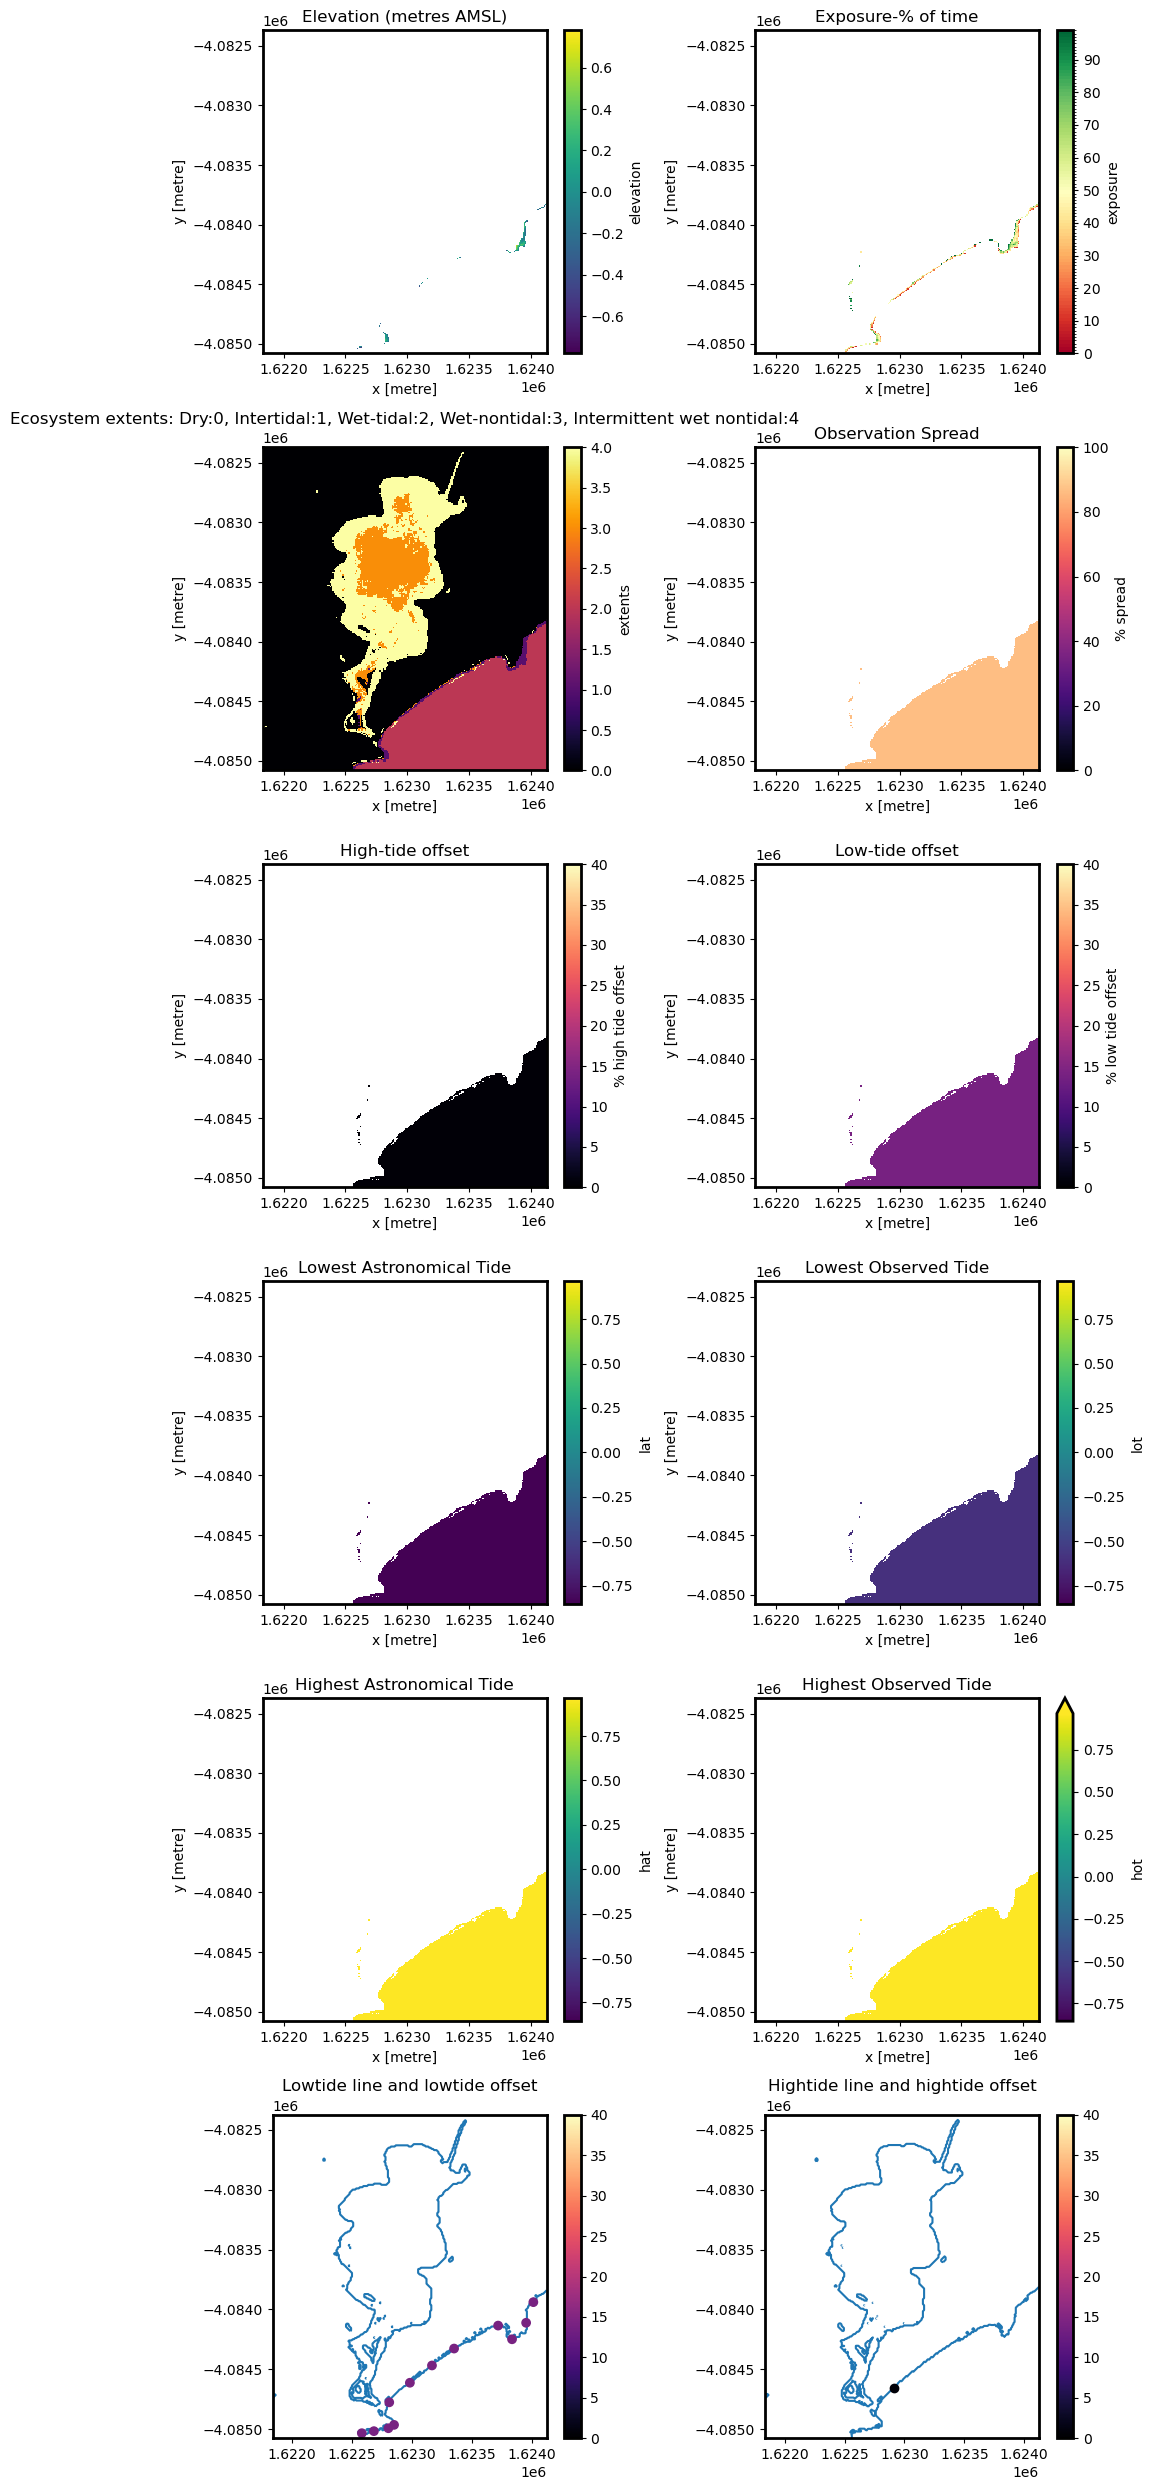

In [77]:
# Set up figure
fig = plt.figure(figsize=(10, 25))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 2)
ax3 = fig.add_subplot(6, 2, 3)
ax4 = fig.add_subplot(6, 2, 4)
ax5 = fig.add_subplot(6, 2, 5)
ax6 = fig.add_subplot(6, 2, 6)
ax7 = fig.add_subplot(6, 2, 7)
ax8 = fig.add_subplot(6, 2, 8)
ax9 = fig.add_subplot(6, 2, 9)
ax10 = fig.add_subplot(6, 2, 10)
ax11 = fig.add_subplot(6, 2, 11)
ax12 = fig.add_subplot(6, 2, 12)

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(ax=ax1, cmap="viridis", interpolation="bilinear")
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax1, interpolation="bilinear"
)
ax1.set_title("Elevation (metres AMSL)")

# Plot Exposure
ds["exposure"].where(ds["exposure"] > 0).plot.imshow(
    ax=ax2, cmap="RdYlGn", levels=np.arange(0, 100, 1)
)
ax2.set_title("Exposure-% of time")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax3, cmap='inferno')
ax3.set_title("Ecosystem extents: Dry:0, Intertidal:1, Wet-tidal:2, Wet-nontidal:3, Intermittent wet nontidal:4")

# Plot the observation spread
# ds["spread"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
ds["spread"].plot.imshow(
    ax=ax4, vmin=0, vmax=100, cmap="magma", cbar_kwargs={"label": "% spread"}
)
ax4.set_title("Observation Spread")

# Plot the high-tide offset
ds["offset_hightide"].plot.imshow(
    ax=ax5, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% high tide offset"}
)
ax5.set_title("High-tide offset")

# Plot the low-tide offset
ds["offset_lowtide"].plot.imshow(
    ax=ax6, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% low tide offset"}
)
ax6.set_title("Low-tide offset")

# Plot the LAT
# ds["lat"].where(ds["extents"] != 2).plot.imshow(
ds["lat"].plot.imshow(
    ax=ax7, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax7.set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["lot"].plot.imshow(
    ax=ax8, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax8.set_title("Lowest Observed Tide")

# Plot the HAT
ds["hat"].plot.imshow(
    ax=ax9, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax9.set_title("Highest Astronomical Tide")

# Plot the HOT
ds["hot"].plot.imshow(
    ax=ax10, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax10.set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax11.set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax11,
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax11, zorder=1)
ax11.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax11.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax12.set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax12,
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax12, zorder=1)
ax12.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax12.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

fig.tight_layout()
plt.show()

In [24]:
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).odc.write_cog('testing.tif')

PosixPath('testing.tif')

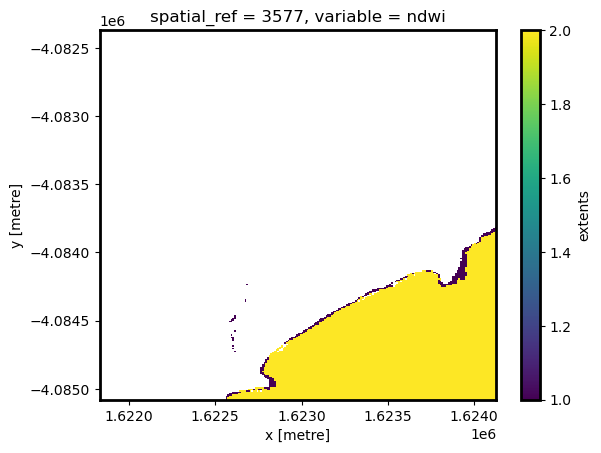

In [66]:
ds.extents.where((ds.extents==1)|(ds.extents==2)).plot()
# ds.extents.where(ds.extents==2).plot()

## Export layers

In [25]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = "testing"

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [26]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"data/interim/{study_area}_{start_date}_{end_date}")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")